# Time Series Classification Using Topological Data Analysis

This notebook shows the basic pipeline of applying Topological Data Analysis for time series classification. We use [Giotto-TDA](https://github.com/giotto-ai/giotto-tda) for working with topology and [UCR](http://www.timeseriesclassification.com/) collection of datasets.

## 0. Imports and Data Loading

In [1]:
# Giotto Installation:
# !pip install -U giotto-tda

In [187]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score

from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Scaler, BettiCurve, PersistenceLandscape, PersistenceEntropy
from gtda.plotting import plot_diagram, plot_betti_curves

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from src.utils import *
from src.TFE import *
from src.nn import *
from src import *

In [188]:
directory_list = get_files_directory_list()
directory_list = sorted(directory_list)

random_index =  51
random_path = directory_list[random_index]

X_train, X_test, y_train, y_test = get_data_from_directory(random_path)
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()
num_classes = np.unique(y_train).shape[0]

print('Dataset: ', random_path)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape:  ', X_test.shape)
print('y_test shape:  ', y_test.shape)
print('num. of class: ', num_classes)

Dataset:  GunPoint
X_train shape:  (50, 150)
y_train shape:  (50,)
X_test shape:   (150, 150)
y_test shape:   (150,)
num. of class:  2


## 1. Background

### 1.1. Common Pipeline

The core idea of Topological Data Analysis (TDA) is to exploit the topological and geometrical properties of data, like shape, connectivity, and etc. to extract informative features. One of the ways of numerical description of such properties is the *Persistent Homology*. Persistent Homology considers data as a point cloud, and tries to find so called holes in point clouds using discretization and triangulation of initial data space space with simplical complexes. The structure of those wholes are described with *Persistence Diagram* (PD) that is a 2D plot that indicates the birth and death of n-dimensional holes in the induced topological spaces. Then, we can utilize different features to describe PD and use them as a input of classifier.

### 1.2. Point Clouds and Takens' Embedding

Since we are going to work with time series data, we need to represent them in some form that will have informative topological behaviour and allow to extract topological features. One way is to utilize the Taken's embedding theorem [1] as it was proposed, for example, in [2]. This theorem states that time series can be reconstructed in so called *phase space* as:

$$
x_n(m, \tau) = (x_n, x_{n+\tau}, ..., x_{n+(m-1)\tau}),
$$

where $m$ is embedding dimension, $\tau$ is the time delay.

Let's look how it can look like for a sample time series.

In [211]:
def plot_embedding(series, time_delay, class_index):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax1.plot(series)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Value")
    ax1.set_title("Initial time seriesm class " + str(class_index))
    ax1.grid()
    sample_embedding = TakensEmbedding(dimension=2, 
                                       time_delay=time_delay, 
                                       parameters_type='fixed').fit_transform(series)
    ax2.scatter(sample_embedding[:,0], sample_embedding[:,1])
    ax2.set_xlabel("$x_t$")
    ax2.set_ylabel("$x_{t+\\tau}$")
    ax2.set_title("Takens Embedding for $m=2$ and $\\tau=" + str(time_delay) + " $, class " + str(class_index))
    ax2.grid()
    plt.tight_layout()

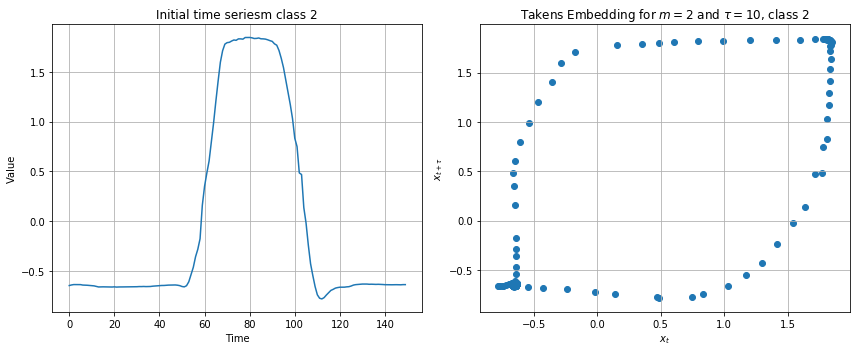

In [212]:
plot_embedding(X_train[0], 10, int(y_train[0]))

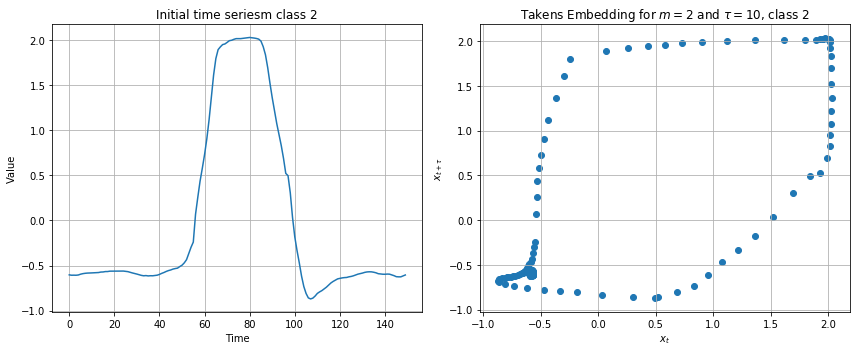

In [213]:
plot_embedding(X_train[14], 10, int(y_train[14]))

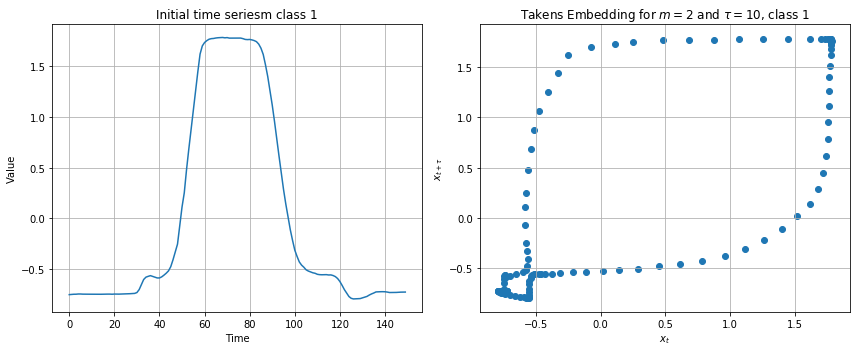

In [214]:
plot_embedding(X_train[3], 10, int(y_train[3]))

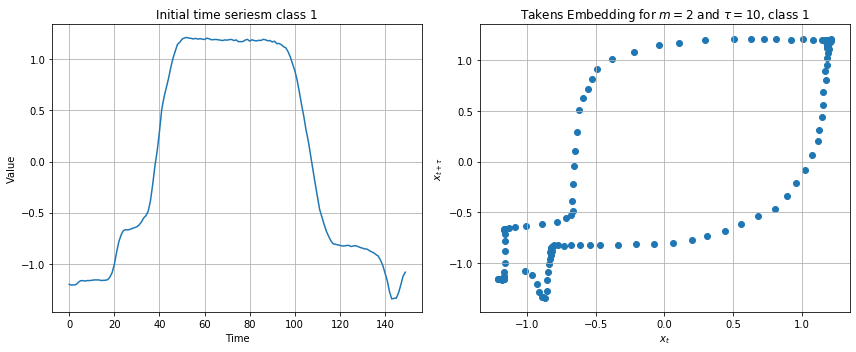

In [215]:
plot_embedding(X_train[13], 10, int(y_train[13]))

We can see that for different classes the embeddings (point clouds) have distinguishable difference in this "tail" part in bottom left of the plot. This difference can be potentially described with topology.

### 1.3. Persistence Diagram

After obtaining point cloud, it is possible to build a Persistence Diagram (PD). One of the ways of obtaining the PD is the Vietoris-Rips Persistent Homology, as proposed, for example, in [3 https://arxiv.org/abs/1905.06071]. PD shows the distribution of holes - their birth and death - for each *homology dimension*.

In [216]:
sample_embedding = TakensEmbedding(dimension=2, 
                                   time_delay=10, 
                                   parameters_type='fixed').fit_transform(X_train[0])

Since Giotto-TDA uses Plotly and doesn't make inline plots, we will duplicate them with static images.

<img src="images/sample_pd.png" />

In [217]:
sample_pd = VietorisRipsPersistence(homology_dimensions=(0, 1)).fit_transform([sample_embedding])[0]
plot_diagram(sample_pd)

Diagram also can be scaled for normalization.

<img src="images/sample_pd_scaled.png" />

In [218]:
sample_pd = Scaler().fit_transform([sample_pd])[0]
plot_diagram(sample_pd)

### 1.4. Alternative Persistence Homology Representation

PD is not the only way to represent Persistence Homology. There are some extensions over PD that can also be useful for feature engineering.

#### 1.4.1. Betti Curve

Let $D$ be a PD. *Betti Curve* is a function $\beta_{D}: \mathbb{R} \rightarrow \mathbb{N}$ whose value $s \in \mathbb{R}$ is the number, counted with multiplicity, of points $(b_i , d_i)$ such that $b_i \leq s < d_i$.

<img src="images/sample_bc.png" />

In [219]:
betti_curve_extractor = BettiCurve()
sample_betti_curve = betti_curve_extractor.fit_transform([sample_pd])[0]
betti_curve_extractor.plot([sample_betti_curve])

#### 1.4.2. Persistence Landscape

A *Persistence Landscape* is a set of $\{{\lambda_k}\}_{k \in \mathbb{N}}$ of functions $\lambda: \mathbb{R} \rightarrow \overline{\mathbb{R}}$, where $\lambda_k$ is the $k$-th *layer* of Persistence Landscape. For the PD $\{ (b_i, d_i) \}$ Persistence Landscape $\lambda$ can defined as letting $\lambda_k$ be $k$-th largest value on set $\{ \Lambda_i(t) \}$, where $\Lambda_i(t) = \left[ min \{ t-b_i, d_i-t \} \right]_+$ and $c_+ := max(c, 0)$.

<img src="images/sample_pl0.png" />
<img src="images/sample_pl1.png" />

In [220]:
persistence_landscape_extractor = PersistenceLandscape(n_layers=2, n_bins=100)
sample_persistence_landscape = persistence_landscape_extractor.fit_transform([sample_pd])[0]
persistence_landscape_extractor.plot([sample_persistence_landscape])

#### 1.4.3. Persistence Entropy

Persistence Entropy is the measure of entropy between points in PD. For PD $D = \{ (b_i, d_i) \}_{i \in I}$ Persistence Entropy is defined by:

$$
E(D) = -\sum_{i \in I} {p_i \log{p_i}},
$$

where $p_i = \frac{d_i - b_i}{L_D}$ and $L_D = \sum_{i \in I}(d_i - b_i)$.

In [222]:
sample_persistence_entropy = PersistenceEntropy().fit_transform([sample_pd])[0]
print(sample_persistence_entropy)

[4.04131086 0.04083675]


### 1.5. Topological Features

After introducing the Persistence Homology and it's derived representations, we can introduced features that we are going to use. Those features will be directly extracted from PD or related sturctures like Betti Curves and Persistence Landscape. First five features are proposed by Pereira in [2], rest of the features are proposed by us. All those topological features were implemented in package `src.TFE`.

#### 1.5.1. Number of Holes

The first feature (or set of features) is the number of holes for each homology dimension. This can be easily calculated with PD. Actually, in the 0th dimension, the holes actually indicate connected components, i.e., vertices that were connected along the filtration.

#### 1.5.2. Maximum Hole Lifetime

Maximum hole lifteime in each dimension helps to identify the most significant hole in each dimension, that is also the farthest point from the diagonal in PD. Note that the one hole that lasted the longest in the filtration indicates a prominent shape-based feature of the data set.

#### 1.5.3. Number of Relevant Holes

The relevant holes for each dimension are the wholes whos lifetime is equal to the maximum hole lifetime with some ratio. In other words, they are the points that are at similar distance from the PD diagonal as the farthest point.

#### 1.5.4. Average Hole Lifetime

Average hole lifetime for each dimensions shows whether the data consist of mosly short-lived holes, or vice versa, the long-lived holes.

#### 1.5.5.  Sum of All Lifetimes

A sum of all hole lifetimes in each dimension can considered as an integral of PD graph. Actually, small sum for dimension shows that data has practically no holes in this dimension.

#### 1.5.6. Pesistence Entropy

Persistence Entropy actually is already a feature and can be informative.

#### 1.5.7. Average Number of Simultaneously Existing Holes

Average number of holes that exist simultaneously for each dimension in some sense can help to describe how sparse the holes are distributed for each dimension. If we represent the PD as set of sorted segments, which is also known as *Persistence Barcode*, this feature can be calculated as an average number of intersections of those segments.

#### 1.5.8. Average Value of Persistence Landscape

Average value of Persistence Landscape can help to handle the structure of Persistence Landscape diagram which can be informative. It's important to notice that in almost all of the studeid cases only Persistence Landscape for 1st homology dimension is informative, so we count this feature only for the 1st homology dimension.

#### 1.5.9. Sum of Betti Numbers

Sum of Betti Numbers can be considered as an integral of Betti Curve for each dimension. This feature is introduced to handle the structure of Betti Curves.

#### 1.5.10. Radius at Maximum Betti Number

This feature is inspired by work [5 Umeda]. It is actually the relative value of $s$ that corresponds to the maximum Betti number for each dimension.

## 2. Evaluation for Sample UCR Dataset

In this part we are going to extract topological features for the dataset [GunPoint](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint) from UCR collection of datasets. The same pipeline was applied to the rest of 1-dimensional time series datasets in UCR.

### 2.1. Topological Features Extraction

To extract Persistence Diagrams and corresponding features, we implemented own scikit-learn style transformers that we used for convenient feature extraction.

In [223]:
%%time

feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=10,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature(),
                                  PersistenceEntropyFeature(),
                                  SimultaneousAliveHolesFeatue(),
                                  AveragePersistenceLandscapeFeature(),
                                  BettiNumbersSumFeature(),
                                  RadiusAtMaxBNFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

CPU times: user 12.2 s, sys: 1.2 s, total: 13.4 s
Wall time: 17.1 s


In [224]:
print('X_train_transformed shape: ', X_train_transformed.shape)
print('X_test_transformed shape:  ', X_test_transformed.shape)

X_train_transformed shape:  (50, 19)
X_test_transformed shape:   (150, 19)


### 2.2. Model Selection in Extracted Features Space

Now we are going to train different models and try to find the best parameters for them using cross-validation technique.

In [225]:
def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    clf_cv = GridSearchCV(model, 
                          param_grid=parameters,
                          cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                          scoring='accuracy', 
                          n_jobs=-1)
    clf_cv.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, clf_cv.best_estimator_.predict(X_train))
    acc_test = accuracy_score(y_test, clf_cv.best_estimator_.predict(X_test))
    print(clf_cv.best_estimator_.__class__.__name__)
    print(clf_cv.best_params_)
    print("Train accuracy: ", acc_train)
    print("Test accuracy: ", acc_test)
    return acc_train, acc_test, clf_cv.best_estimator_, clf_cv.best_params_

Support Vector Machine:

In [226]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}
acc_train, acc_test, model, model_params = evaluate_model(SVC(random_state=42), parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

SVC
{'C': 0.1, 'kernel': 'linear'}
Train accuracy:  0.98
Test accuracy:  0.86


XGBoost:

In [227]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.9


K Nearest Neighbours:

In [228]:
parameters = {"n_neighbors": [3, 5, 7, 11,]}
acc_train, acc_test, model, model_params = evaluate_model(KNeighborsClassifier(n_jobs=-1), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

KNeighborsClassifier
{'n_neighbors': 5}
Train accuracy:  0.96
Test accuracy:  0.8533333333333334


CatBoost:

In [229]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250],
              "early_stopping_rounds": [2, 5, 8, 10, 50, 200]}
acc_train, acc_test, model, model_params = evaluate_model(CatBoostClassifier(random_state=42, verbose=False), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CatBoostClassifier
{'early_stopping_rounds': 2, 'max_depth': 2, 'n_estimators': 50}
Train accuracy:  0.98
Test accuracy:  0.9


### 2.3 Dimensionality Reduction with Variational Autoencoder

Variational Autoencoder (VAE) is a powerful dimensionality reduction technique. We are going to apply it to reduce the extracted topoligcal features space dimensionality.

In [16]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

device = get_device()
batch_size = 32
latent_dim = num_classes * 4

In [17]:
scale = StandardScaler()
scale.fit(X_train_transformed)

X_train_transformed_dim = handle_dim(X_train_transformed, scale)
X_test_transformed_dim = handle_dim(X_test_transformed, scale)

y_hot_train = one_hot_encoding(y_train)
y_hot_test = one_hot_encoding(y_test)

dataset_train = TimeSeriesDataLoader(X_train_transformed_dim, y_hot_train, batch_size)
dataset_test = TimeSeriesDataLoader(X_test_transformed_dim, y_hot_test, batch_size)

test_data = torch.zeros(dataset_train.dataset[:][0].shape)

In [18]:
vae = VariationalAutoencoder(batch_size=batch_size, latent_dims=latent_dim, test_data=test_data)
vae = vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=2e-3, weight_decay=1e-5)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 13873


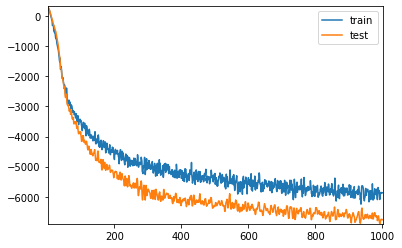

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (fc_mu): Linear(in_features=256, out_features=8, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=8, out_features=96, bias=True)
    (conv2): ConvTranspose1d(32, 1, kernel_size=(15,), stride=(3,), padding=(1,))
  )
)

In [19]:
train_AE(1000, vae, dataset_train, dataset_test, optimizer, device, verbose=True)

In [20]:
from_vae_loader2numpy = lambda model, x: model.transform(x.dataset[:][0]).cpu().detach().numpy()

z_train = from_vae_loader2numpy(vae, dataset_train)
z_test = from_vae_loader2numpy(vae, dataset_test)

In [21]:
print("Reduced train size: ", z_train.shape)

Reduced train size:  (50, 8)


Now let's train our models on reduced dataset.

Support Vector Machine:

In [22]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}
acc_train, acc_test, model, model_params = evaluate_model(SVC(random_state=42), parameters, z_train,
                                                          y_train, z_test, y_test)

SVC
{'C': 10, 'kernel': 'sigmoid'}
Train accuracy:  0.98
Test accuracy:  0.9266666666666666


XGBoost:

In [23]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, z_train,
                                                          y_train, z_test, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.8266666666666667


K Nearest Neighbours:

In [24]:
parameters = {"n_neighbors": [3, 5, 7, 11,]}
acc_train, acc_test, model, model_params = evaluate_model(KNeighborsClassifier(n_jobs=-1), 
                                                          parameters, z_train,
                                                          y_train, z_test, y_test)

KNeighborsClassifier
{'n_neighbors': 5}
Train accuracy:  0.98
Test accuracy:  0.8733333333333333


CatBoost:

In [25]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250],
              "early_stopping_rounds": [2, 5, 8, 10, 50, 200]}
acc_train, acc_test, model, model_params = evaluate_model(CatBoostClassifier(random_state=42, verbose=False), 
                                                          parameters, z_train,
                                                          y_train, z_test, y_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CatBoostClassifier
{'early_stopping_rounds': 2, 'max_depth': 15, 'n_estimators': 200}
Train accuracy:  1.0
Test accuracy:  0.9066666666666666


In this case, VAE helped to achieve best accuracy on test set.

### 2.4. ANN classifier

Finally, let's try to use an ANN as a classifier.

In [26]:
neural_net_params = {'in_features=latent_dim': latent_dim,
                     'out_features': num_classes,
                     'depth': 4}

net = ANN(latent_dim, num_classes, device)
net.fit(z_train, y_train)

y_train_pred = net.predict(z_train)
y_test_pred = net.predict(z_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on train: ", acc_train)
print("Accuracy on test: ", acc_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



Accuracy on train:  0.98
Accuracy on test:  0.9266666666666666


/home/ubuntu/workspace/ml/project/Time-Series-Classification/src/utils.py:84: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



## 3. Imputation Study

Now let's see how the combinations of proposed features influence the quality, and for which types of datasets they work worse or better.

### 3.1. Feature Importance

First let's ensure that our proposed features matter, for that, let's train classifier only with Pereira's features. For that, let's take a classifier that produced good accuracy on a test set, for example, XGBoost.

In [31]:
feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=10,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

In [32]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 100}
Train accuracy:  1.0
Test accuracy:  0.8666666666666667


Still accuracy is not bad, but it decreased w.r.t. to initial accuracy. Now let's check the feature importance with Logistic Regression and XGBoost.

In [33]:
feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=10,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature(),
                                  PersistenceEntropyFeature(),
                                  SimultaneousAliveHolesFeatue(),
                                  AveragePersistenceLandscapeFeature(),
                                  BettiNumbersSumFeature(),
                                  RadiusAtMaxBNFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

In [60]:
def plot_feature_importances(feature_importances, feature_names, model_name):
    plt.figure(figsize=(7, 5))
    features = np.sort(feature_importances)
    names = [feature_names[i] for i in np.argsort(feature_importances)]
    plt.barh(range(len(features)), features, align='center')
    plt.title(model_name + " Feature Importance")
    plt.yticks(np.arange(0, len(names) + 1, 1), names)

In [41]:
feature_names = ["Hole_num_0", "Hole_num_1", "Max_lifetime_0", "Max_lifetime_1", "Relevant_num_0", 
                 "Relevant_num_1", "Average_lifetime_0", "Average_lifetime_1", "Sum_lifetime_0", 
                 "Sum_lifetime_1", "Entropy_0", "Entropy_1", "Sim_alive_0", "Sim_alive_1", "Average_landscape_1",
                 "Betti_num_sum_0", "Betti_num_sum_1", "Rad_max_bn_0", "Rad_max_bn_1"]

In [35]:
parameters = {"C": [10 ** i for i in range(-3, 5)]}
acc_train, acc_test, model, model_params = evaluate_model(LogisticRegression(), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

LogisticRegression
{'C': 1}
Train accuracy:  0.98
Test accuracy:  0.8533333333333334


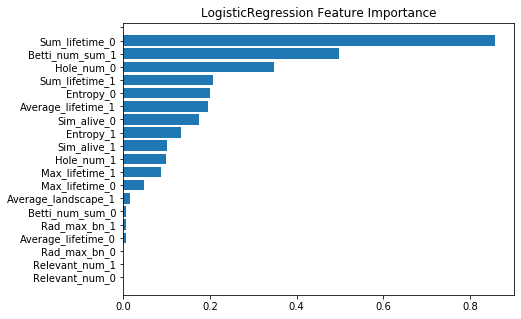

In [62]:
plot_feature_importances(abs(model.coef_[0]), feature_names, "LogisticRegression")

In [63]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.9


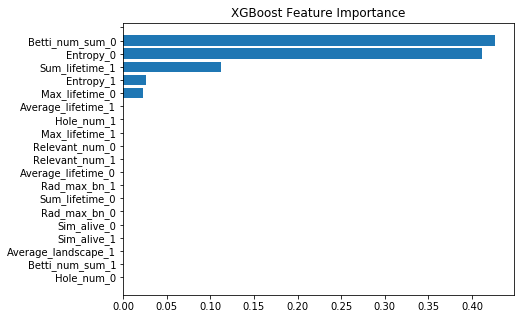

In [65]:
plot_feature_importances(model.feature_importances_, feature_names, "XGBoost")

We can see that here our proposed features have quite high importance in both cases.

### 3.2. Studying Multiclass Dataset

Here we got a binary classification problem. Now let's check how these features will perform on multiclass problem. Let's take a [Trace](http://www.timeseriesclassification.com/description.php?Dataset=Trace) dataset.

In [230]:
directory_list = get_files_directory_list()
directory_list = sorted(directory_list)

random_index =  115
random_path = directory_list[random_index]

X_train, X_test, y_train, y_test = get_data_from_directory(random_path)
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()
num_classes = np.unique(y_train).shape[0]

print('Dataset: ', random_path)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape:  ', X_test.shape)
print('y_test shape:  ', y_test.shape)
print('num. of class: ', num_classes)

Dataset:  Trace
X_train shape:  (100, 275)
y_train shape:  (100,)
X_test shape:   (100, 275)
y_test shape:   (100,)
num. of class:  4


Let's look at sample embedding for all classes from this dataset:

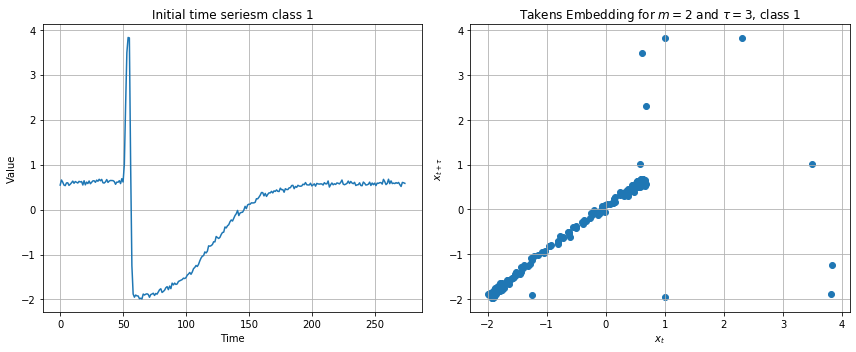

In [231]:
plot_embedding(X_train[0], 3, int(y_train[0]))

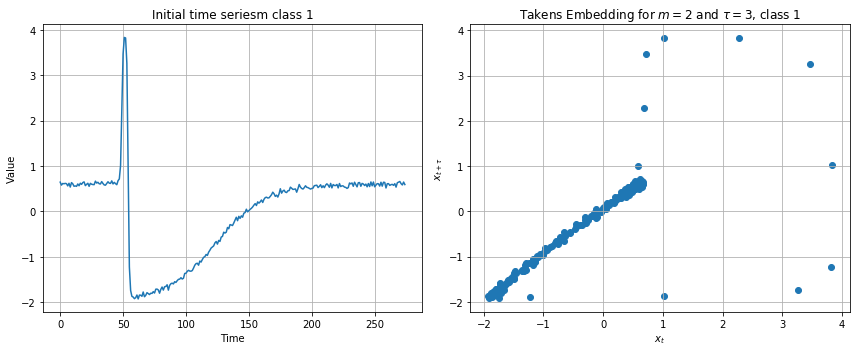

In [232]:
plot_embedding(X_train[7], 3, int(y_train[7]))

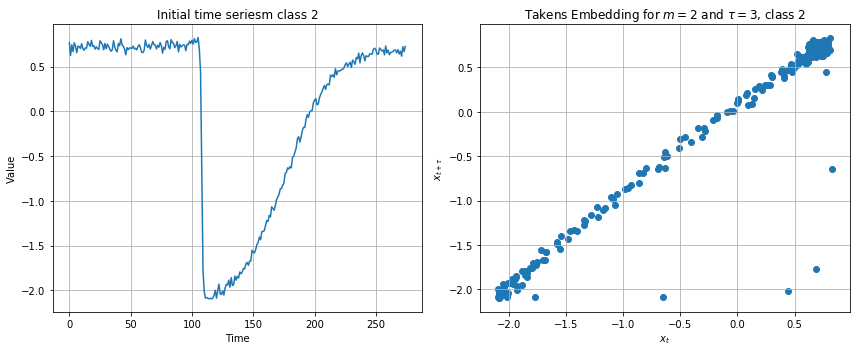

In [233]:
plot_embedding(X_train[1], 3, int(y_train[1]))

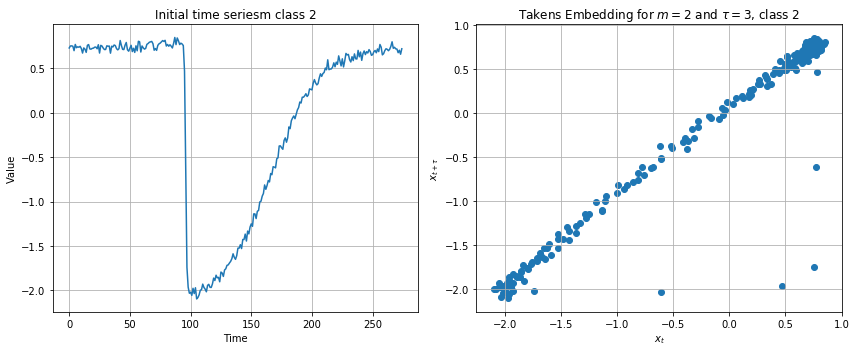

In [234]:
plot_embedding(X_train[17], 3, int(y_train[17]))

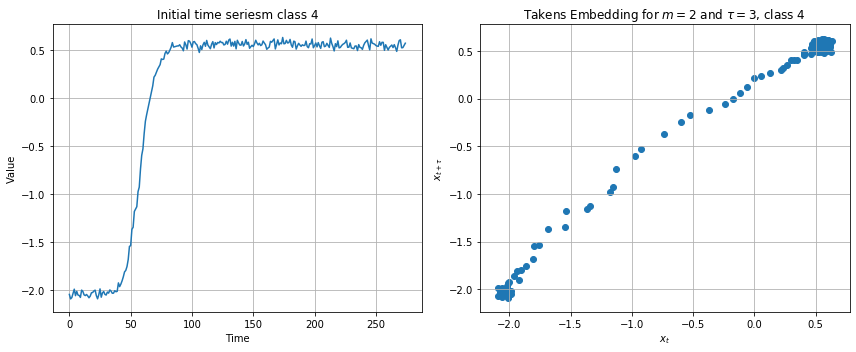

In [235]:
plot_embedding(X_train[2], 3, int(y_train[2]))

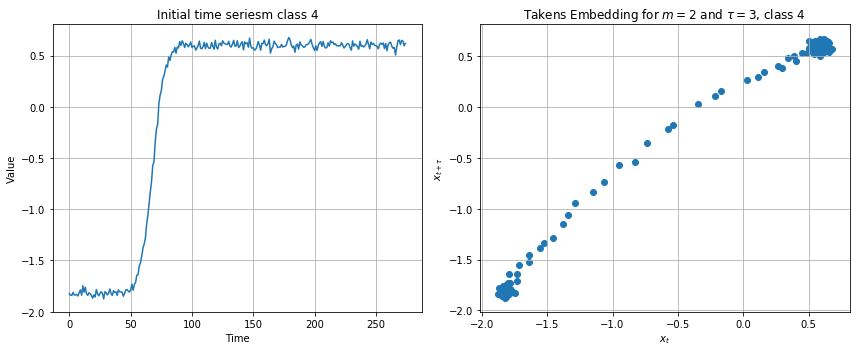

In [236]:
plot_embedding(X_train[10], 3, int(y_train[10]))

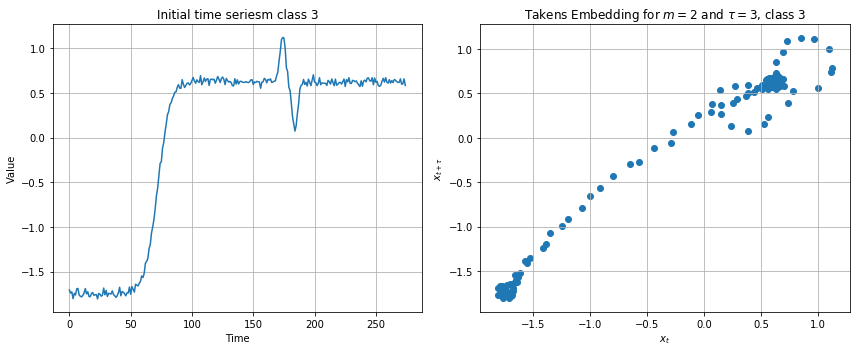

In [237]:
plot_embedding(X_train[3], 3, int(y_train[3]))

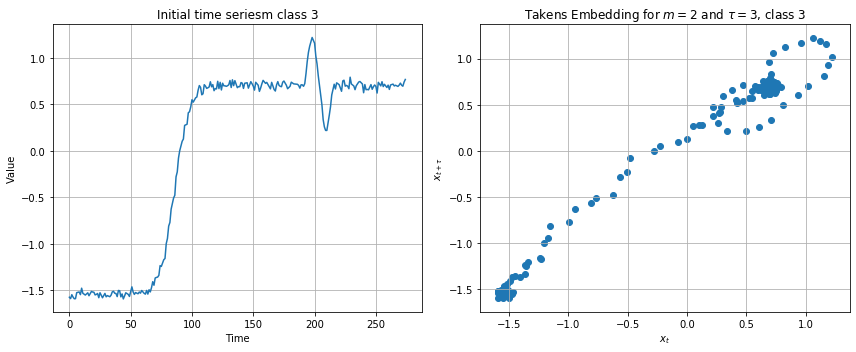

In [238]:
plot_embedding(X_train[13], 3, int(y_train[13]))

It seems that embeddings of different classes produce quite distinguishable embeddings (point clouds). So, here topological features can produce good results. Let's check it.

In [160]:
feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=3,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature(),
                                  PersistenceEntropyFeature(),
                                  SimultaneousAliveHolesFeatue(),
                                  AveragePersistenceLandscapeFeature(),
                                  BettiNumbersSumFeature(),
                                  RadiusAtMaxBNFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

Support Vector Machine:

In [76]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}
acc_train, acc_test, model, model_params = evaluate_model(SVC(random_state=42), parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

SVC
{'C': 1, 'kernel': 'linear'}
Train accuracy:  1.0
Test accuracy:  0.98


XGBoost:

In [77]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.99


And again let's check the feature importance:

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression
{'C': 1}
Train accuracy:  0.99
Test accuracy:  0.98


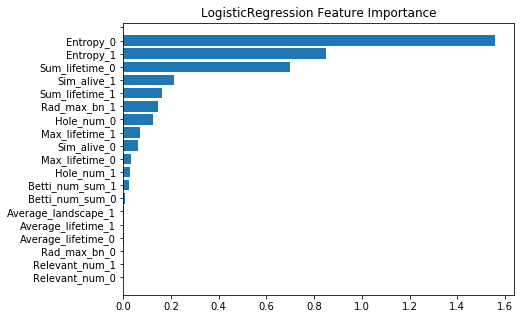

In [162]:
parameters = {"C": [10 ** i for i in range(-3, 5)]}
acc_train, acc_test, model, model_params = evaluate_model(LogisticRegression(max_iter=1000), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)
plot_feature_importances(abs(model.coef_[0]), feature_names, "LogisticRegression")

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.99


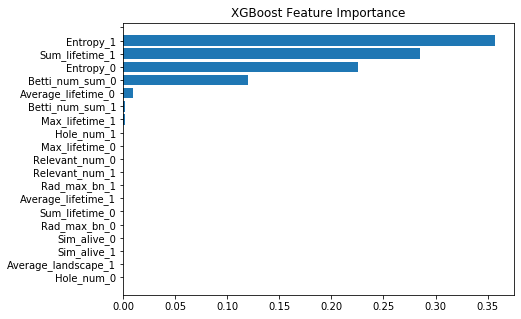

In [163]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)
plot_feature_importances(model.feature_importances_, feature_names, "XGBoost")

### 3.3. Dataset Where TDA Fails

Let's study dataset where topological features can potentially fail. Consider the [ECGFiveDays](http://www.timeseriesclassification.com/description.php?Dataset=ECGFiveDays) dataset.

In [239]:
directory_list = get_files_directory_list()
directory_list = sorted(directory_list)

random_index =  30
random_path = directory_list[random_index]

X_train, X_test, y_train, y_test = get_data_from_directory(random_path)
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()
num_classes = np.unique(y_train).shape[0]

print('Dataset: ', random_path)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape:  ', X_test.shape)
print('y_test shape:  ', y_test.shape)
print('num. of class: ', num_classes)

Dataset:  ECGFiveDays
X_train shape:  (23, 136)
y_train shape:  (23,)
X_test shape:   (861, 136)
y_test shape:   (861,)
num. of class:  2


Let's take a look at embeddings:

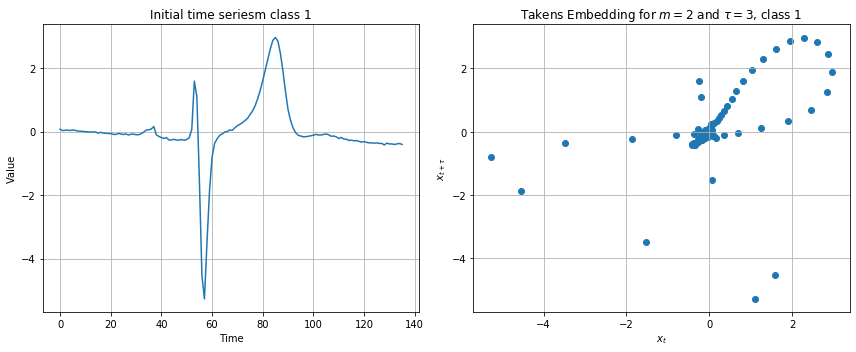

In [240]:
plot_embedding(X_train[1], 3, int(y_train[1]))

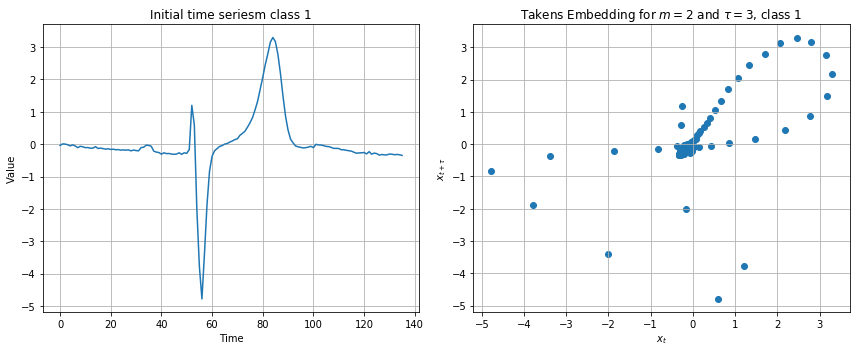

In [241]:
plot_embedding(X_train[10], 3, int(y_train[10]))

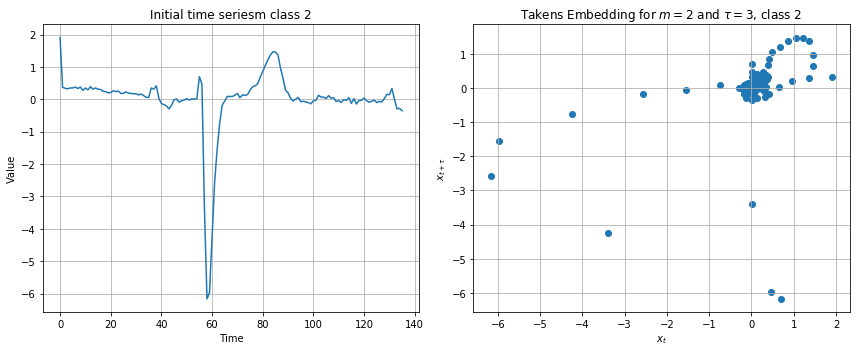

In [242]:
plot_embedding(X_train[2], 3, int(y_train[2]))

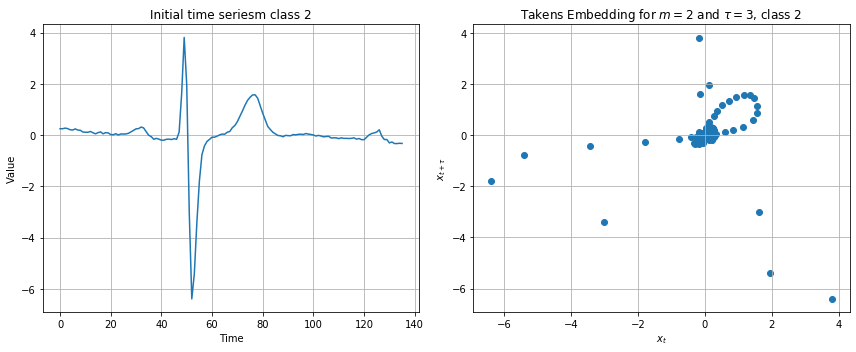

In [243]:
plot_embedding(X_train[5], 3, int(y_train[5]))

We can notice that for this dataset we produced embeddings that are less distinguishable than in previous cases. The main difference here is the "scale" of this loop, and for topology it is much harder to handle difference in scale rather than distinguishable difference in core form. Thus, results can be poor for this dataset.

In [184]:
feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=3,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature(),
                                  PersistenceEntropyFeature(),
                                  SimultaneousAliveHolesFeatue(),
                                  AveragePersistenceLandscapeFeature(),
                                  BettiNumbersSumFeature(),
                                  RadiusAtMaxBNFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

Support Vector Machine:

In [185]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}
acc_train, acc_test, model, model_params = evaluate_model(SVC(random_state=42), parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

SVC
{'C': 1000, 'kernel': 'poly'}
Train accuracy:  0.7391304347826086
Test accuracy:  0.6596980255516841


XGBoost:

In [186]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 50}
Train accuracy:  1.0
Test accuracy:  0.6771196283391405


As expected, results are not so satisfiable. But still they potentially can be improved with tuning Takens embeddings parameters and more complicated classifiers.

## 4. Conclusions

In this work we studied the potential of Topological Data Analysis and topological features for time series classification problem. This notebook shows the part of the whole pipeline and analysis for different datasets, for the rest of the work please refer the report.

To sum up, we can figure out following highlits:

* Persistence Homology and Persistence Diagrams are powerful tools for describing data from topology point of view

* Features that are extracted from PD shows the topological and geometrical behaviour of the data

* Features extracted from constructions above the PD like Betti Curves, Persistence Landscape and Persistence Entropy showed good performance

* Techniques like Dimensionality Reduction still can be applied for topological features and can improve the performance

* Topological features seem to work well for data that has distinguishable difference in geometry and topology for different classes. If the difference is not very distinguishable, topology features can fail in this case.

In future work other properties and applications of TDA and topological features can be studied to improve the performance for different UCR datasets along with more accurate parameters tuning.